In [1]:
# Reimplementing the paper: Unsupervised Representation Learning By Predicting Image Rotations

from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from test_tube import Experiment  
from pytorch_lightning.callbacks import ModelCheckpoint

In [41]:
# options
batch_size = 4 # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.1      # learning rate
momentum = 0.9
weight_decay = 5e-4

In [42]:
# okay okay okay
# So uh okay okay okay
# Do I implement a custom dataset? 
# Do I implement a custom dataloader? 
# maybe include a collate_fn

In [4]:
t = np.arange(12).reshape((3,2,2))
t

array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]]])

In [5]:
# Test:
# t = np.arange(12).reshape((3,2,2))
# rotate_90(t, 1)
# rotate_90(t, 2)
# rotate_90(t, 4).shape

def rotate_90(img, n):
    return np.rot90(img, n, (1, 2))   

In [6]:
def collate(batch):
    '''
    batch:  list of tuples [(x, y), (x, y), ... (x, y)] where x is an image tensor of shape [3, 32, 32] 
            and y is the CIFAR-10 class label (int)
            
    Augments the batch with four rotations of each image. 
    Changes the label for each image to simply be one of the four rotations: 0, 1, 2 or 3. 
            
    returns: list of [imgs, labels], where len(list) is 4 times the length of original input list. 
    '''
    
    imgs = []
    labels = []
    for (x, y) in batch:
        # TODO: we can try randomizing the rotation here.  
        for n in [0, 1, 2, 3]:
            imgs.append(torch.FloatTensor(rotate_90(x.numpy(), n).copy()))
            labels.append(n)
    
    return [imgs, labels]

In [53]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=False, download=True, transform=data_transform)

# train_dist_sampler = torch.utils.data.distributed.DistributedSampler(trainset)
# test_dist_sampler = torch.utils.data.distributed.DistributedSampler(testset)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)

Files already downloaded and verified
Files already downloaded and verified


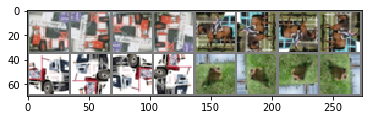

In [78]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.imshow(np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)) * 0.5 + 0.5)